 # DistilBERT Statement Processing

- ¿ Por qué se expolora esta vía? 

## Flujo de trabajo
1. Procesamiento del `statement`con DistilBERT (Este notebook)
   - `DistilBERTokenizer`+ `DistilBERTModel`. *Salida*: `embeddings`
   - Extracción de temas con `BERTopic`. *Salida*: `topics`
   - Filtrado de nuevas características
2. Añadir el resultado de este notebook a un procesado más simple de características (`CatBoostClasiffier`)
3. Evaluar el modelo

In [1]:
#!pip install bertopic

In [2]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import numpy as np
import seaborn as sns


## Obtención del dataset

Cargamos el dataset original y obtenemos la columna `statement`

In [3]:
df = pd.read_csv("../../data/processed/train_limpieza_v1.csv")

In [4]:
df.head(5)

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_affiliation_uni,party_affiliation_category_map
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,republican,political-affiliation
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,democrat,political-affiliation
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,democrat,political-affiliation
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,non-define,non-define,none,none,other-political-groups
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,non-define,Wisconsin,republican,republican,political-affiliation


## Selección de columnas

In [5]:
df_statements = df["statement"]
df_statements

0       China is in the South China Sea and (building)...
1       With the resources it takes to execute just ov...
2       The (Wisconsin) governor has proposed tax give...
3       Says her representation of an ex-boyfriend who...
4       At protests in Wisconsin against proposed coll...
                              ...                        
8945    If Rhode Island does a hybrid [retirement] pla...
8946    The new health care law will force seniors int...
8947    The health insurance plan that (members of Con...
8948    No one in American history has moved from a Ju...
8949    Says the Army is spending $7 million to sponso...
Name: statement, Length: 8950, dtype: object

## Procesamiento con DistilBERT

### Tokenización Y Embeddings

#### DistilBERTokenizer

In [6]:
# Tokenizador y modelo DistilBERT (sin cabeza de clasificación)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

#### DistilBERTModel

In [7]:
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [8]:
# Uso de GPU
# Asegúrate de usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

### Embeddings

Definimos la función `get_embedding`, que obtiene un vector numérico para cada `statement`

In [9]:
def get_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch, CLS_token, hidden]
        return cls_embedding.squeeze().cpu().numpy()

 Y se la aplicamos a nuestra columna de `statements`

In [10]:
# Aplicar sobre todos los statements
embeddings = []
for text in tqdm(df["statement"].tolist()):
    emb = get_embedding(text)
    embeddings.append(emb)

100%|██████████████████████████████████████████████| 8950/8950 [06:27<00:00, 23.12it/s]


In [11]:
embed_array = np.stack(embeddings)
statements_df = pd.DataFrame(embed_array, columns=[f"embed_{i}" for i in range(embed_array.shape[1])])

### Extracción de `topics`

#### Uso de BERTopics

In [12]:
from bertopic import BERTopic

In [13]:
# Crear el modelo de topics
topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)

In [14]:
# Aplicar sobre statement
topics, _ = topic_model.fit_transform(df_statements)

2025-05-15 21:29:06,217 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

2025-05-15 21:30:14,890 - BERTopic - Embedding - Completed ✓
2025-05-15 21:30:14,891 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-15 21:30:45,452 - BERTopic - Dimensionality - Completed ✓
2025-05-15 21:30:45,454 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-15 21:30:45,911 - BERTopic - Cluster - Completed ✓
2025-05-15 21:30:45,920 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-15 21:30:46,312 - BERTopic - Representation - Completed ✓


In [15]:
# Almacenamos en el dataframe
df["topic"] = topics
df.head(5)

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,party_affiliation_uni,party_affiliation_category_map,topic
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,republican,political-affiliation,-1
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,democrat,political-affiliation,0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,democrat,political-affiliation,1
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,non-define,non-define,none,none,other-political-groups,-1
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,non-define,Wisconsin,republican,republican,political-affiliation,1


### Guardado

In [16]:
# Guardamos el modelo y la tokenización
model.save_pretrained("distilbert_model/")
tokenizer.save_pretrained("distilbert_model/")

('distilbert_model/tokenizer_config.json',
 'distilbert_model/special_tokens_map.json',
 'distilbert_model/vocab.txt',
 'distilbert_model/added_tokens.json')

In [24]:
# Guardamos los topics
topic_model.save("bertopic_model")

2025-05-15 21:34:46,870 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [26]:
# Guardamos los embeddings en csv
filename = f"../../data/processed/embedded_statements.csv"
statements_df.to_csv(filename, index=False)
print(f"Statements guardados en {filename}")

# Guardamos los topics en csv
filename = f"../../data/processed/train_limpieza_con_topics.csv"
df.to_csv(filename, index=False)
print(f"Statements guardados en {filename}")

Statements guardados en ../../data/processed/embedded_statements.csv
Statements guardados en ../../data/processed/train_limpieza_con_topics.csv


## Exploración de Embeddings

In [27]:
statements_df

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,-0.389664,-0.030861,-0.202854,-0.159517,-0.094729,-0.196138,0.094816,0.539899,-0.345786,-0.201171,...,0.174090,-0.091622,-0.011743,-0.109035,0.137417,0.048593,-0.112992,-0.126134,0.531850,0.058125
1,0.002147,-0.216556,-0.492738,0.018217,-0.043286,-0.225065,0.112890,0.025084,0.053101,-0.537698,...,0.026458,-0.070488,0.320287,-0.124055,0.193578,-0.184102,0.136245,-0.157255,0.394348,0.209791
2,-0.406977,-0.370509,-0.427060,-0.140057,-0.022885,-0.130742,0.132194,0.237262,-0.272489,-0.132721,...,-0.069538,-0.042304,0.284898,0.010718,0.322190,-0.237688,0.158044,0.074949,0.274027,0.373261
3,-0.068771,-0.173259,-0.223535,-0.239831,0.320225,-0.006796,0.087655,0.384122,-0.059824,0.091258,...,-0.004094,-0.323747,0.119084,-0.287066,0.059405,-0.054894,-0.050123,0.001896,0.266967,0.186472
4,0.006399,-0.261764,-0.599629,-0.164757,-0.210141,-0.039297,0.283767,0.350801,-0.164125,-0.117358,...,-0.135115,-0.448344,-0.041354,-0.142127,0.367174,-0.125917,-0.211319,-0.116877,0.088836,0.532682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.258182,-0.370823,-0.011442,0.008085,0.113996,-0.301600,0.106719,0.225586,-0.223235,-0.302322,...,-0.141747,-0.183876,0.268436,-0.037008,0.163775,-0.069397,-0.098898,-0.123367,0.308161,0.402638
8946,-0.239116,-0.350976,-0.103532,-0.102904,-0.008095,-0.134420,0.405853,-0.012234,0.007266,-0.562050,...,-0.044380,-0.060108,0.287437,0.059314,0.061904,-0.239270,0.027955,-0.021551,0.093451,0.284410
8947,-0.168373,0.080929,-0.252726,-0.052055,-0.023912,-0.152136,0.141036,0.397718,-0.366922,-0.366423,...,0.099768,-0.127551,0.175393,-0.163322,0.145168,-0.223640,0.207204,0.007989,0.144971,0.841863
8948,-0.401886,-0.325358,-0.136829,-0.149456,-0.073566,-0.295790,-0.039490,0.243115,-0.400915,-0.292720,...,0.058717,0.198039,0.298836,-0.057057,0.318708,-0.159159,-0.055992,-0.148654,0.386383,0.652841


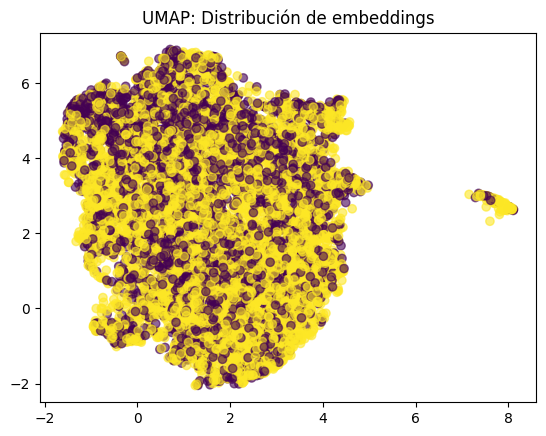

In [28]:
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2)
reduced = umap.fit_transform(statements_df)

plt.scatter(reduced[:, 0], reduced[:, 1], c=df["label"], cmap="viridis", alpha=0.6)
plt.title("UMAP: Distribución de embeddings")
plt.show()

Esta representación visual de los statements muestra que hay agrupación posible en los statements, a pesar de que la distribución de la clase 'label' esté mezclada en ambos grupos. Vamos a intentar detectar embeddings relevantes. 

### Detección de embeddings relevantes

In [60]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Combina embeddings con la etiqueta
X = statements_df.copy()
y = df["label"]  # Asegúrate que esté alineado con embed_df

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar el modelo
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=8,
    auto_class_weights="Balanced",
    eval_metric='F1',
    verbose=100
)

catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=30)

# Predecir en validación
y_pred = catboost_model.predict(X_val)

# Métricas
print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=3))

0:	learn: 0.6281068	test: 0.6121545	best: 0.6121545 (0)	total: 496ms	remaining: 4m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6328135776
bestIteration = 66

Shrink model to first 67 iterations.

Classification Report:
              precision    recall  f1-score   support

           0      0.476     0.540     0.506       631
           1      0.730     0.676     0.702      1159

    accuracy                          0.628      1790
   macro avg      0.603     0.608     0.604      1790
weighted avg      0.640     0.628     0.633      1790



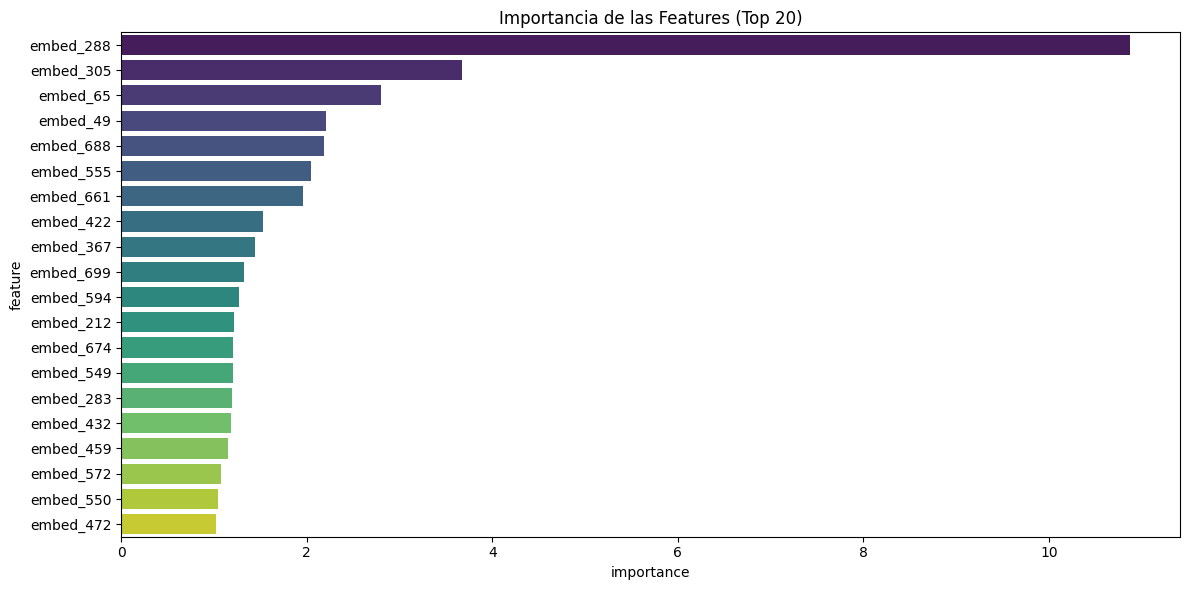

In [46]:
# Obtener importancias
importances = catboost_model.get_feature_importance()
features = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x="importance", y="feature", palette="viridis")
plt.title("Importancia de las Features (Top 20)")
plt.tight_layout()
plt.show()

### Filtrado

In [61]:
# Filtrar top 50
top_50_features = importance_df.head(50)["feature"].tolist()

# Reducir X a esas columnas
X_train_top = X_train[top_50_features]
X_val_top = X_val[top_50_features]

# Reentrenar modelo con solo las top 50
model_top = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    auto_class_weights="Balanced",
    eval_metric='F1',
    verbose=100
)

model_top.fit(X_train_top, y_train, eval_set=(X_val_top, y_val), early_stopping_rounds=30)


0:	learn: 0.6251620	test: 0.5925314	best: 0.5925314 (0)	total: 32.4ms	remaining: 16.2s
100:	learn: 0.6838209	test: 0.6146314	best: 0.6252677 (80)	total: 953ms	remaining: 3.77s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.625267669
bestIteration = 80

Shrink model to first 81 iterations.


In [62]:
# Predicción
y_pred_top = model_top.predict(X_val_top)

# Evaluar
from sklearn.metrics import classification_report

print("\nClassification Report (Top 50 features):")
print(classification_report(y_val, y_pred_top, digits=3))


Classification Report (Top 50 features):
              precision    recall  f1-score   support

           0      0.474     0.604     0.531       631
           1      0.746     0.635     0.686      1159

    accuracy                          0.624      1790
   macro avg      0.610     0.619     0.609      1790
weighted avg      0.650     0.624     0.632      1790



## Resultado

## Subida a Kaggle solo con Statement

Tenemos que reproducir los pasos que se tomaron con el dataset original, por lo que se toman los embeddings de test 

In [49]:
df_test = pd.read_csv("../../data/processed/test_limpieza_v1.csv")# Embedding a test
test_embeddings = []
for text in tqdm(df_test["statement"].tolist()):
    emb = get_embedding(text)
    test_embeddings.append(emb)

100%|█████████████████████████████| 3836/3836 [02:50<00:00, 22.53it/s]


In [50]:
embed_array_test = np.stack(test_embeddings)
embed_df_test = pd.DataFrame(embed_array_test, columns=[f"embed_{i}" for i in range(embed_array_test.shape[1])])

In [51]:
# Guardamos los embeddings en csv
filename = f"../../data/processed/embedded_test.csv"
embed_df_test.to_csv(filename, index=False)
print(f"Statements guardados en {filename}")

Statements guardados en ../../data/processed/embedded_test.csv


### Todas las características + CatBoost

In [63]:
X_test = embed_df_test.copy()
y_pred_test = catboost_model.predict(X_test)

In [64]:
import datetime 
# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/DistilBERT_Statements_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/DistilBERT_Statements_2025-05-15_21-59-17.csv


In [65]:
X_test = embed_df_test[top_50_features]
y_pred_test = model_top.predict(X_test)

In [66]:
# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/DistilBERT_Statements_top50_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/DistilBERT_Statements_top50_2025-05-15_21-59-18.csv


# Resultados:
- CatBoost Simple con Statement: 
- CatBoost Simple con Statement y Topic:
- CatBoost Simple bajando el número de iteraciones y subiendo la profundidad:
Con top50:
- CatBoost Simple con Statement: 
- CatBoost Simple con Statement y Topic:
- CatBoost Simple bajando el número de iteraciones y subiendo la profundidad: